In [1]:
import sys
sys.path.append('../code')
import utils, spike_train_functions, lfp_functions

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from bycycle import BycycleGroup
from bycycle.utils import get_extrema_df

from scipy.stats import wasserstein_distance
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import seaborn as sns


In [2]:
data_path = '../data/'
session_files = {
    # 'SPK121107_MI_PMd_TT_NOGO_ob001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII-SORTED-01_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121107_PMv_TT_NOGO_ob001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII-SORTED-02_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat'},
    # 'RUSRH120619_MI_PMd_TT_KG_TC_NOGO_Ob001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXI_corrected_gNTSNR_split.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'RUS_map_MI_PMd.mat'},
    # 'SPK121001_MI_PMd_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR_split.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    'SPK121004_MI_PMd_TT_SEQSIM001': {
        'event_file': 'ev_explicit.mat',
        'unit_file': 'DSXII_corrected_gNTSNR_split.mat',
        'lfp_file': '30x_downsample.mat',
        'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121005_MI_PMd_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR_split.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121001_PMv_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121004_PMv_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121005_PMv_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'}
    
}

In [182]:
def process_session(session_name, session_dict):
    # Loading files for specific recording session
    # ============================================
    
    # Load spiking data and electrode map
    fpath = f'../data/{session_name}'
    unit_fname = f'{fpath}/{session_name}_{session_dict["unit_file"]}'

    event_fname = f'{fpath}/{session_name}_{session_dict["event_file"]}'
    lfp_fname = f'{fpath}/{session_name}_{session_dict["lfp_file"]}'
    map_fname = f'../data/{session_dict["map_file"]}'
    
    # Load electrode map, single unit spiking, and LFP (.nsx), and experiment data
    mapping_dict = sio.loadmat(map_fname)
    single_unit_dict = sio.loadmat(unit_fname)
    nsx_dict = sio.loadmat(lfp_fname)
    experiment_dict = utils.load_cgid_ev_explicit(event_fname)
    ev_explicit = sio.loadmat(event_fname)
    
    # Process electrode map
    emap_dict = {'label_idx': np.stack(mapping_dict['map_struct'][0]['Num']).squeeze() - 1,
               'row': np.stack(mapping_dict['map_struct'][0]['Row']).squeeze(),
               'col': np.stack(mapping_dict['map_struct'][0]['Column']).squeeze(),
               'area': np.stack(mapping_dict['map_struct'][0]['SubArrayName']).squeeze()}
    emap_df_full = pd.DataFrame(emap_dict)

    # Process single unit data
    single_unit_dict = sio.loadmat(unit_fname)

    sorted_timestamps = single_unit_dict['sorted_timestamps'][0]
    unit_timestamps = [sorted_timestamps[unit_idx].squeeze() for unit_idx in range(len(sorted_timestamps))]
    num_units = len(unit_timestamps)
    unit_names = np.array(range(num_units))

    unit_electrodes = single_unit_dict['unit_index'][0,:] - 1
    unit_areas = [emap_df_full['area'].values[elec_idx] for elec_idx in unit_electrodes]
    
    # Process experiment timestamps
    go = experiment_dict['go']
    stmv = experiment_dict['stmv']
    contact = experiment_dict['contact']
    obpres = experiment_dict['obpres']
    obj = experiment_dict['ob']
    grip = experiment_dict['grip']
    
    reaction_time = stmv - go
    seq = (go - obpres) > 1 # Identify "sequential" trials
    
    # Process LFP data
    # ================
    samp_freq = 1000
    nsx_duration = nsx_dict['out'][0][0]['MetaTags'][0][0]['DataDurationSec']

    lfp_data_raw = nsx_dict['out'][0][0]['Data']
    lfp_times_raw = np.linspace(0, nsx_duration, lfp_data_raw.shape[1]).squeeze()
    
    lfp_corr = np.corrcoef(lfp_data_raw)

    win_start = -2
    win_len = 2

    # event_dict = {'go': go}
    # window_dict = {'pre': (win_start, win_len)}

    # event_dict = {'grasppres':grasppres, 'obpres': obpres}
    event_dict = {'go': go}
    window_dict = {'pre': (win_start, win_len)}


    lfp_data_col = list()
    event_col, event_times_col, window_col, tstart_col = list(), list(), list(), list()
    trial_col, object_col, grip_col, seq_col = list(), list(), list(), list()

    for window_name, (st_offset, max_time) in window_dict.items():
        max_samples = int(max_time * samp_freq)
        for event_name, event_ts in event_dict.items():
            object_col.extend(obj)
            grip_col.extend(grip)
            seq_col.extend(seq)
            for trial_idx, event_time in enumerate(event_ts):
                    event_col.append(event_name)
                    event_times_col.append(event_time)
                    window_col.append(window_name)
                    trial_col.append(trial_idx)

                    tstart = event_time + st_offset
                    tstop = tstart + max_time
                    start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
                    stop_idx = start_idx + max_samples

                    tstart_col.append(tstart)

                    lfp_windowed = lfp_data_raw[:, start_idx:stop_idx]
                    lfp_data_col.append(lfp_windowed)

    lfp_dict = {'event': event_col, 'window': window_col, 'lfp': lfp_data_col, 'event_time': event_times_col,
                'object': object_col, 'seq': seq_col,
                'grip': grip_col, 'trial': trial_col, 'tstart': tstart_col}

    lfp_df = pd.DataFrame(lfp_dict)

    # Extract beta oscillations with cycle by cycle analysis
    # ======================================================
    lfp_data_array = np.stack(lfp_df['lfp'].values)

    num_trial_segs, num_channels, num_times = lfp_data_array.shape
    trial_idx_map = lfp_df['trial'].values # Need to grap actual trial indices
    tstart_map = lfp_df['tstart'].values
    event_map = lfp_df['event'].values
    window_map = lfp_df['window'].values

    x_times = np.linspace(0, num_times / samp_freq, num_times)
    
    bycycle_lfp_array = np.transpose(lfp_data_array, (1,0,2))
    fs = samp_freq
    f_beta = (12,30)

    # **May need to adjust these thresholds*
    thresholds = {'amp_fraction': 0.5, 'amp_consistency': .5, 'period_consistency': .4, 
                  'monotonicity': .5, 'min_n_cycles': 2}

    compute_kwargs = {'burst_method': 'cycles', 'threshold_kwargs': thresholds, 'center_extreme': 'trough'}


    bg = BycycleGroup(thresholds=thresholds)
    bg.fit(bycycle_lfp_array, fs, f_beta, axis=0, progress='tqdm')

    # Combine by cycle analysis for all electrodes into dataframe
    bg_df_list = list()
    assert len(bg.df_features) == num_channels
    for channel_idx in range(num_channels):
        assert len(bg.df_features[channel_idx]) == num_trial_segs
        for trial_seg_idx in range(num_trial_segs):
            trial_idx = trial_idx_map[trial_seg_idx]
            trial_tstart = tstart_map[trial_seg_idx]
            event_name = event_map[trial_seg_idx]
            window_name = window_map[trial_seg_idx]


            temp_df = bg.df_features[channel_idx][trial_seg_idx].copy()
            temp_df['channel'] = np.repeat(channel_idx, len(temp_df))
            temp_df['trial'] = np.repeat(trial_idx, len(temp_df))
            temp_df['tstart'] = np.repeat(trial_tstart, len(temp_df))
            temp_df['event'] = np.repeat(event_name, len(temp_df))
            temp_df['window'] = np.repeat(window_name, len(temp_df))
            temp_df['trial_seg'] = np.repeat(trial_seg_idx, len(temp_df))
            temp_df['grip'] = np.repeat(grip[trial_idx], len(temp_df))
            temp_df['object'] = np.repeat(obj[trial_idx], len(temp_df))
            temp_df['seq'] = np.repeat(seq[trial_idx], len(temp_df))
            temp_df['reaction_time'] = np.repeat(reaction_time[trial_idx], len(temp_df))

            bg_df_list.append(temp_df)

    bg_df = pd.concat(bg_df_list)

    bg_df.to_pickle(f'{fpath}/{session_name}_bycycle_df.pkl')
    
    noise_channels = np.where(np.mean(lfp_corr,axis=0) < 0.2)[0]
    bg_df = bg_df[~np.isin(bg_df['channel'], noise_channels)]
    clean_channels = bg_df['channel'].unique()
    
    # Extract spiking data aligned to beta troughs
    
    filter_df = bg_df.copy()
    filter_df['sample_peak'] = (filter_df['sample_peak'] / fs) + filter_df['tstart']
    filter_df['sample_last_trough'] = (filter_df['sample_last_trough'] / fs) + filter_df['tstart']
    filter_df['sample_next_trough'] = (filter_df['sample_next_trough'] / fs) + filter_df['tstart']
    filter_df = filter_df.dropna(axis=0)

    
    # ** NEED TO SET THRESHOLDS**
    filter_df = filter_df[filter_df['is_burst']]
    # filter_df = filter_df[filter_df['band_amp'] > 15]

    # wstart, wstop = -1, 1
    
    electrode_df = filter_df.copy()
    electrode_idx = clean_channels[10]  # this is really an arbitrary choice
    electrode_df = electrode_df[electrode_df['channel']==electrode_idx]

    # Extract event ts for each electrode
    event_ts = electrode_df['sample_next_trough']

    # Filter spike times to event ts
#     st_data = spike_train_functions.st_window_split(
#         unit_timestamps, event_ts, wstart=wstart, wstop=wstop)

#     st_data_go = spike_train_functions.st_window_split(
#         unit_timestamps, go, wstart=wstart, wstop=wstop)

#     st_data_stmv = spike_train_functions.st_window_split(
#         unit_timestamps, stmv, wstart=wstart, wstop=wstop)

    
    res_dict = {'bg_df': bg_df, 'experiment_dict': experiment_dict,
                'unit_timestamps': unit_timestamps, 'event_dict': event_dict,
                'window_dict': window_dict, 'thresholds': thresholds, 'clean_channels': clean_channels,
                'noise_channels': noise_channels, 'fs': fs, 'single_unit_dict': single_unit_dict,
                'unit_areas': unit_areas, 'unit_electrodes': unit_electrodes, 'ev_explicit': ev_explicit,
                'lfp_data_array': lfp_data_array, 'lfp_corr': lfp_corr, 'win_start': win_start,
                'win_len': win_len
    
                # 'st_data': st_data, 'st_data_go': st_data_go, 'st_data_stmv': st_data_stmv,
               }
    
    return res_dict

In [183]:
processed_session = dict()
for session_name, session_dict in session_files.items():
    print(session_name)
    res_dict = process_session(session_name, session_dict)
    processed_session[session_name] = res_dict

SPK121004_MI_PMd_TT_SEQSIM001


Computing Bycycle Features: 100%|██████████| 96/96 [00:09<00:00, 10.66it/s]


In [238]:
session_names = list(processed_session.keys())
res_dict = processed_session[session_names[0]]

experiment_dict = res_dict['experiment_dict']
lfp_data_array = res_dict['lfp_data_array']
stmv = experiment_dict['stmv']
go = experiment_dict['go']
obpres = experiment_dict['obpres']

reaction_time = stmv - go
seq = (go - obpres) > 1 # Identify "sequential" trials

win_start, win_len = res_dict['win_start'], res_dict['win_len']
                     
bg_df = res_dict['bg_df']
clean_channels = res_dict['clean_channels']
unit_timestamps = res_dict['unit_timestamps']
unit_electrodes = res_dict['unit_electrodes']
unit_areas = res_dict['unit_areas']

fs = 1000
filter_df = bg_df.copy()
# filter_df['sample_peak'] = (filter_df['sample_peak'] / fs) + filter_df['tstart']
# filter_df['sample_last_trough'] = (filter_df['sample_last_trough'] / fs) + filter_df['tstart']
# filter_df['sample_next_trough'] = (filter_df['sample_next_trough'] / fs) + filter_df['tstart']
filter_df['sample_next_trough'] = (filter_df['sample_next_trough'] / fs) 

filter_df = filter_df.dropna(axis=0)


# ** NEED TO SET THRESHOLDS**
filter_df = filter_df[filter_df['is_burst']]
# filter_df = filter_df[filter_df['band_amp'] > 15]

wstart, wstop = -0.1, 0.1
# wstart, wstop = -0.05, 0.05



# electrode_df = filter_df.copy()
# electrode_idx = clean_channels[10]  # this is really an arbitrary choice
# electrode_df = electrode_df[electrode_df['channel']==electrode_idx]

# Extract event ts for each electrode
# event_ts = electrode_df['sample_next_trough']

# mask = electrode_df['seq'].values
# mask = electrode_df['grip'].values == 1
# mask = electrode_df['object'].values == 1

# filter_feature = 'reaction_time'
# mask = electrode_df[filter_feature] > np.percentile(electrode_df[filter_feature].values, 50)
    
# event_ts_cond1 = electrode_df[mask]['sample_next_trough'].values
# event_ts_cond2 = electrode_df[~mask]['sample_next_trough'].values


In [244]:


st_data, st_data_cond1, st_data_cond2 = list(), list(), list()

st_data_go = spike_train_functions.st_window_split(
        unit_timestamps, go, wstart=0.0, wstop=0.2)

st_data_go_seq = spike_train_functions.st_window_split(
        unit_timestamps, go[seq], wstart=0.0, wstop=0.2)

st_data_go_noseq = spike_train_functions.st_window_split(
        unit_timestamps, go[~seq], wstart=0.0, wstop=0.2)

st_data_stmv = spike_train_functions.st_window_split(
        unit_timestamps, stmv, wstart=0.0, wstop=0.2)

st_data_stmv_seq = spike_train_functions.st_window_split(
        unit_timestamps, stmv[seq], wstart=0.0, wstop=0.2)

st_data_stmv_noseq = spike_train_functions.st_window_split(
        unit_timestamps, stmv[~seq], wstart=0.0, wstop=0.2)

for electrode_idx in clean_channels:
    electrode_df = filter_df.copy()
    electrode_df = electrode_df[electrode_df['channel']==electrode_idx]
    # electrode_df = electrode_df.sort_values('band_amp', ascending=False).groupby('trial').first()
    
    # filter_feature = 'reaction_time'
    # mask = electrode_df[filter_feature] > np.percentile(electrode_df[filter_feature].values, 50)
    
    mask = electrode_df['seq'].values

    # Extract event ts for each electrode
    event_ts = electrode_df['sample_next_trough']
    
    event_ts_cond1 = electrode_df[mask]['sample_next_trough'].values
    event_ts_cond2 = electrode_df[~mask]['sample_next_trough'].values

    filter_units = np.where(unit_electrodes == electrode_idx)[0]
    filter_timestamps = [unit_timestamps[unit_idx] for unit_idx in filter_units]

    # Filter spike times to event ts
    filter_st_data = spike_train_functions.st_window_split(
        filter_timestamps, event_ts, wstart=wstart, wstop=wstop)
    
    filter_st_data_cond1 = spike_train_functions.st_window_split(
        filter_timestamps, event_ts_cond1, wstart=wstart, wstop=wstop)
    
    filter_st_data_cond2 = spike_train_functions.st_window_split(
        filter_timestamps, event_ts_cond2, wstart=wstart, wstop=wstop)


    st_data.extend(filter_st_data)
    st_data_cond1.extend(filter_st_data_cond1)
    st_data_cond2.extend(filter_st_data_cond2)

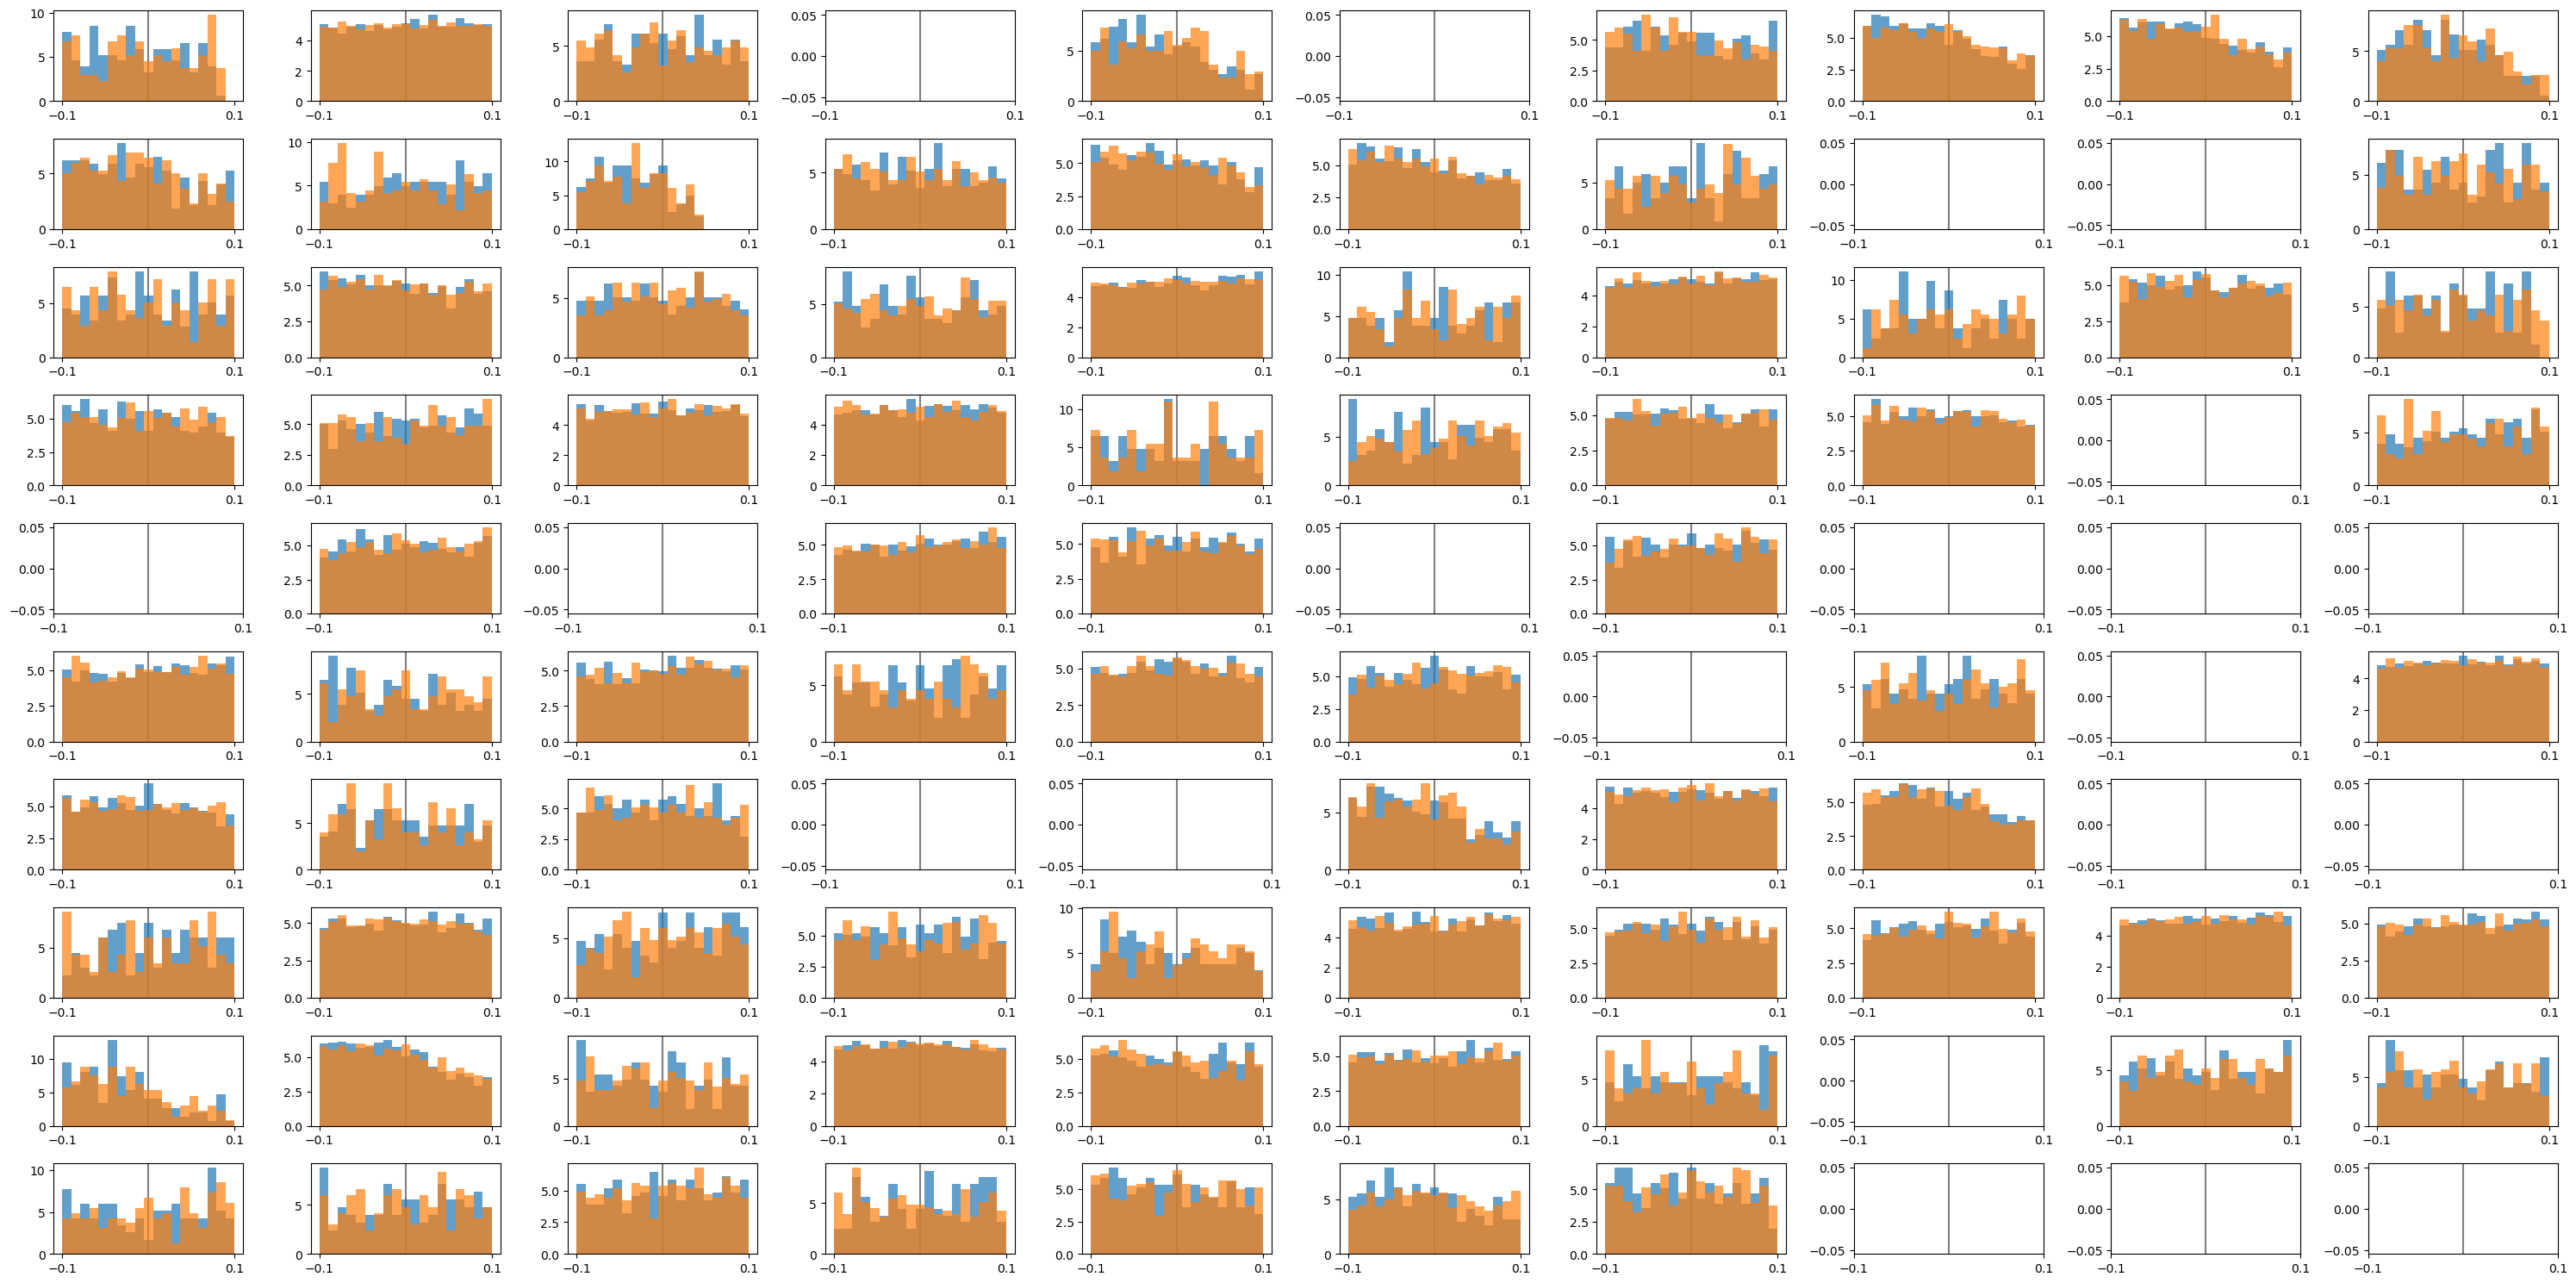

In [245]:
area_color = {'MI': 'C0', 'PMd': 'C1'}

bins = np.linspace(wstart, wstop, 20)
plt.figure(figsize=(30,15))
for plot_idx, unit_idx in enumerate(range(0, 100)):
    area = unit_areas[unit_idx]
    plt.subplot(10,10,plot_idx+1)
    # _ = plt.hist(np.concatenate(st_data_stmv[unit_idx]) + wstart, bins=bins, alpha=0.4, density=True, color='k')
    # _ = plt.hist(np.concatenate(st_data[unit_idx]) + wstart, bins=bins, alpha=0.7, density=False, color=area_color[area])
    
    _ = plt.hist(np.concatenate(st_data_cond1[unit_idx]) + wstart, bins=bins, color='C0', alpha=0.7, density=True)
    _ = plt.hist(np.concatenate(st_data_cond2[unit_idx]) + wstart, bins=bins, color='C1', alpha=0.7, density=True)
    
    plt.axvline(x=0, color='grey', zorder=-1100)
    plt.xticks([wstart, wstop])
    # plt.yticks([])
plt.tight_layout()

In [246]:
def get_fano_factor(st_data):
    num_units = len(st_data)
    st_counts, st_means, st_var, st_ff = list(), list(), list(), list()
    for unit_idx in range(num_units):
        unit_counts = list(map(np.size, st_data[unit_idx]))
        unit_mean = np.mean(unit_counts)
        unit_var = np.var(unit_counts)
              
        unit_ff = unit_var / unit_mean
        
        st_counts.append(unit_counts)
        st_means.append(unit_mean)
        st_var.append(unit_var)
        st_ff.append(unit_ff)
        
    st_hist_data = [np.concatenate(st_data[unit_idx]) for unit_idx in range(len(st_data))]
    st_median = [np.median(st_hist_data[unit_idx]) for unit_idx in range(num_units)]
    st_entropy = [scipy.stats.entropy(st_hist_data[unit_idx]) for unit_idx in range(num_units)]
    
        
    return {'st_counts': st_counts, 'st_means': st_means, 'st_var': st_var, 'st_ff': st_ff,
            'st_median': st_median, 'st_entropy': st_entropy}



In [247]:
go_seq_ff_dict = get_fano_factor(st_data_go_seq)
go_noseq_ff_dict = get_fano_factor(st_data_go_noseq)

stmv_seq_ff_dict = get_fano_factor(st_data_stmv_seq)
stmv_noseq_ff_dict = get_fano_factor(st_data_stmv_noseq)

cond1_ff_dict = get_fano_factor(st_data_cond1)
cond2_ff_dict = get_fano_factor(st_data_cond2)

/tmp/ipykernel_1906687/2397922535.py:9: RuntimeWarning: invalid value encountered in scalar divide
  unit_ff = unit_var / unit_mean


Text(0, 0.5, 'Entropy')

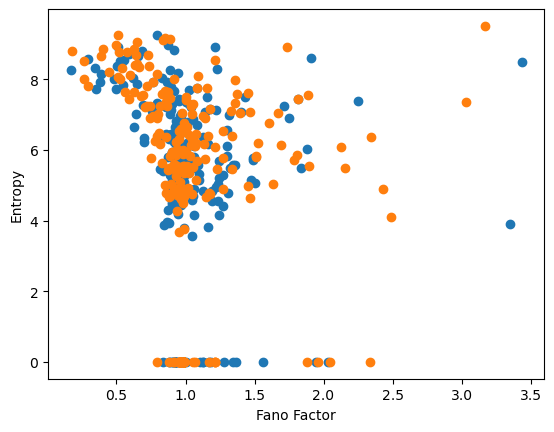

In [248]:
plt.scatter(go_seq_ff_dict['st_ff'], cond1_ff_dict['st_entropy'])
plt.scatter(go_noseq_ff_dict['st_ff'], cond2_ff_dict['st_entropy'])

plt.xlabel('Fano Factor')
plt.ylabel('Entropy')
# plt.axhline(y=0.2, color='k')
# plt.ylim(-0.0, 0.4)

Text(0, 0.5, 'Go Simultaneous')

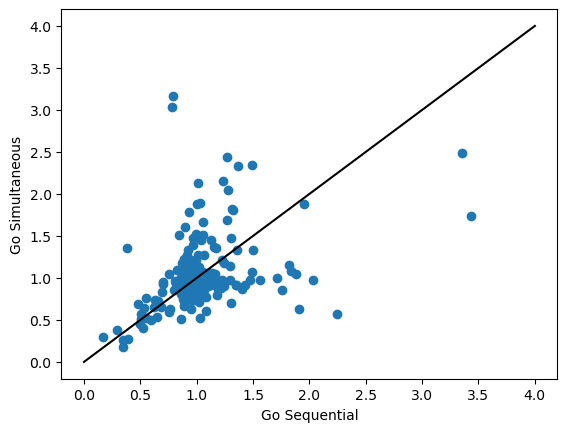

In [210]:
plt.plot(np.array([0,4]), np.array([0,4]), color='k')
plt.scatter(go_seq_ff_dict['stplt.plot(np.array([0,4]), np.array([0,4]), color='k')
plt.scatter(go_seq_ff_dict['st_ff'], go_noseq_ff_dict['st_ff'])
plt.xlabel('Go Sequential')
plt.ylabel('Go Simultaneous')
# plt.ylim(0,4)_ff'], go_noseq_ff_dict['st_ff'])
plt.xlabel('Go Sequential')
plt.ylabel('Go Simultaneous')
# plt.ylim(0,4)

Text(0, 0.5, 'stmv Simultaneous')

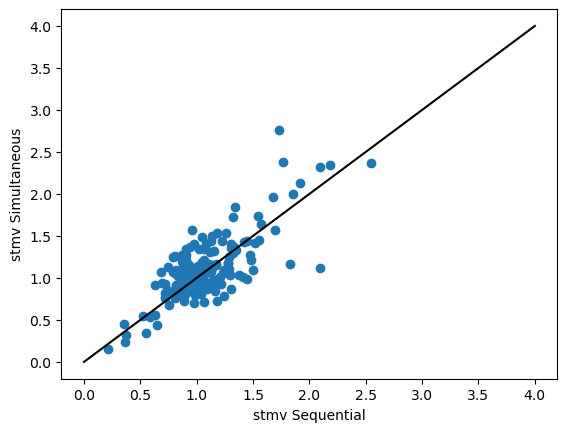

In [211]:
plt.plot(np.array([0,4]), np.array([0,4]), color='k')
plt.scatter(stmv_seq_ff_dict['st_ff'], stmv_noseq_ff_dict['st_ff'])
plt.xlabel('stmv Sequential')
plt.ylabel('stmv Simultaneous')
# plt.ylim(0,4)

In [8]:
def get_sig_bursts(sig, bg_df, trial_idx, electrode_idx):
    df_features = bg_df.copy()
    df_features = df_features[np.all(df_features[['trial_seg', 'channel']] == [trial_idx, electrode_idx], axis=1)]

    is_osc = np.zeros(len(sig), dtype=bool)
    df_osc = df_features.loc[df_features['is_burst']]
    start = 0
    times = np.arange(0, len(sig) / fs, 1 / fs)
    _, side_e = get_extrema_df(df_features)

    for cyc in df_osc.to_dict('records'):

        samp_start_burst = int(cyc['sample_last_' + side_e]) - int(fs * start)
        samp_end_burst = int(cyc['sample_next_' + side_e] + 1) - int(fs * start)

        is_osc[samp_start_burst:samp_end_burst] = True

    sig_bursts =  np.ma.array(sig, mask=np.invert(is_osc))
    
    return sig_bursts

In [9]:
trial_list = range(120)
electrode_idx = 60

sig_list, sig_bursts_list = list(), list()
for trial_idx in trial_list:
    sig = lfp_data_array[trial_idx, electrode_idx, :]
    sig_bursts = get_sig_bursts(sig, bg_df, trial_idx, electrode_idx)
    
    sig_list.append(sig)
    sig_bursts_list.append(sig_bursts)


In [10]:
x_times = np.linspace(0, lfp_data_array.shape[2] / fs, lfp_data_array.shape[2])

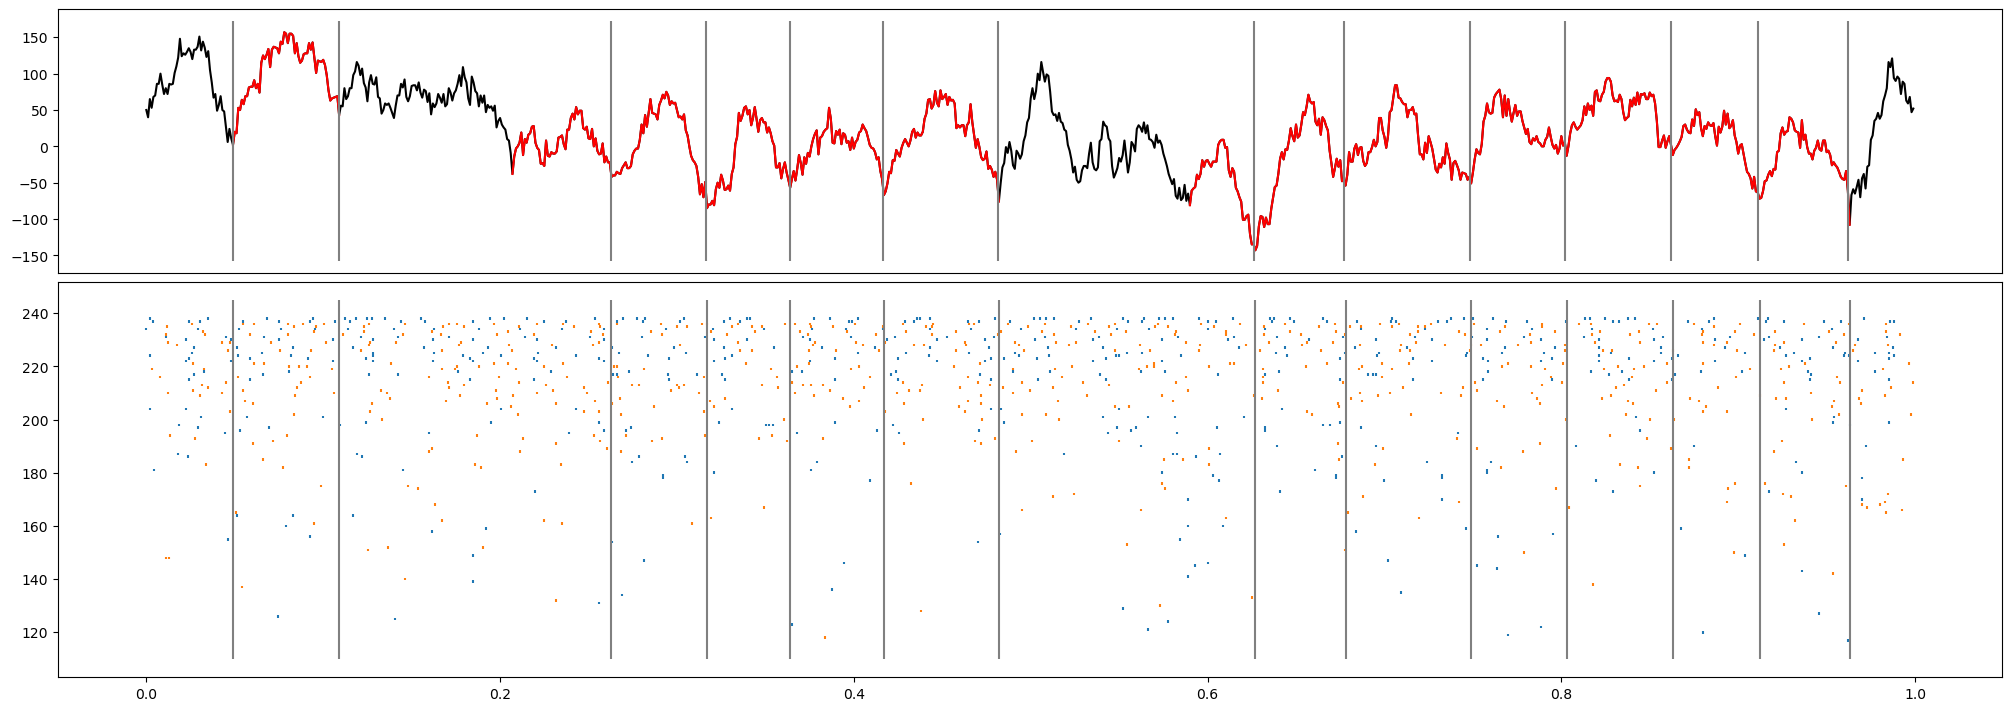

In [11]:
st_data_plot = spike_train_functions.st_window_split(unit_timestamps, go, wstart=win_start, wstop=win_start+win_len)
unit_idx_col, unit_ts_col, area_col, trial_col, electrode_col = list(), list(), list(), list(), list()
for unit_idx, unit_trial_ts in enumerate(st_data_plot):
    for trial_idx, unit_ts in enumerate(unit_trial_ts):
        unit_idx_col.append(unit_idx)
        unit_ts_col.append(unit_ts)
        area_col.append(unit_areas[unit_idx])
        electrode_col.append(unit_electrodes[unit_idx])
        trial_col.append(trial_idx)
        

unit_dict = {'unit_idx': unit_idx_col, 'unit_ts': unit_ts_col, 'area': area_col,
             'trial': trial_col, 'electrode': electrode_col}
unit_df = pd.DataFrame(unit_dict)
unit_df['counts'] = unit_df['unit_ts'].map(len)


trial_idx = 100

fig, axes = plt.subplots(2, 1, figsize=(20,7), constrained_layout=True, height_ratios=[1, 1.5])

# Plot Burst
axes[0].plot(x_times, sig_list[trial_idx], color='k')
axes[0].plot(x_times, sig_bursts_list[trial_idx], color='r')
_ = axes[0].set_xticks([])

plot_mask = np.logical_and(filter_df['trial_seg'] == trial_idx, filter_df['channel'] == electrode_idx)
peak_times = filter_df[plot_mask]['sample_next_trough'].values 
ymin, ymax = axes[0].get_ylim()
axes[0].vlines(peak_times, ymin=ymin, ymax=ymax, color='grey')


unit_trial_df = unit_df[unit_df['trial'] == trial_idx]
unit_trial_df = unit_trial_df.sort_values(by='counts')

for offset, (unit_y_pos, (unit_ts, area)) in enumerate(unit_trial_df[['unit_ts', 'area']].iterrows()):
    plot_y_pos = np.repeat(unit_y_pos, len(unit_ts))
    # plt.scatter(unit_ts, plot_y_pos, marker='|', color=area_color[area])
    plt.eventplot(unit_ts, lineoffsets=offset, color=area_color[area])
ymin, ymax = axes[1].get_ylim()
axes[1].vlines(peak_times, ymin=ymin, ymax=ymax, color='grey')

In [12]:
lfp_data_array.shape

(192, 96, 1000)

In [13]:
beta_waveforms = list()
for electrode_idx in clean_channels:
    for trial_idx in range(lfp_data_array.shape[0]):
        plot_mask = np.logical_and(filter_df['trial_seg'] == trial_idx, filter_df['channel'] == electrode_idx)
        peak_times = filter_df[plot_mask]['sample_next_trough'].values
        
        for peak_time in peak_times:
            peak_idx = np.argmin(np.abs(x_times - peak_time))
         
            beta_waveforms.append(lfp_data_array[trial_idx, electrode_idx, (peak_idx-50):(peak_idx+50)])